In [35]:
# import system libs
import glob
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import resample
from sklearn.model_selection import KFold

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [36]:
def undersample_dataframe(df, target_column):
    # Menghitung jumlah sampel untuk setiap kelas
    label_counts = df[target_column].value_counts()

    # Menentukan jumlah sampel terkecil pada kelas
    min_label_count = label_counts.min()

    # Inisialisasi dataframe kosong untuk menyimpan sampel undersampled
    undersampled_df = pd.DataFrame()

    # Melakukan undersampling pada setiap kelas
    for label in label_counts.index:
        # Memilih sampel acak dengan jumlah yang sesuai dari setiap kelas
        undersampled_class_df = resample(
            df[df[target_column] == label],
            replace=False,  # Tidak mengganti sampel yang dipilih
            n_samples=min_label_count,  # Jumlah sampel yang sesuai
            random_state=42  # Seed untuk reproduksi
        )

        # Menyimpan sampel undersampled
        undersampled_df = pd.concat([undersampled_df, undersampled_class_df])

    return undersampled_df


In [37]:
# Function that create dataframe for train, and test data
def create_df(df_fix):
    # train dataframe
    df = df_fix
    strat = df['labels']
    train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)

    return train_df, test_df

In [38]:
def create_model_data_test (test_df, batch_size):

    # define model parameters
    img_size = (224, 224)
    channels = 3 # channel BGR atau Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    ts_length = len(test_df)
    test_batch_size = 32

    # Fungsi ini yang akan digunakan dalam generator data gambar untuk augmentasi data, hanya mengambil gambar dan mengembalikannya lagi
    def scalar(img):
        return img

    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return test_gen

In [39]:
def create_model_data_train (train_df, batch_size):

    # define model parameters
    img_size = (224, 224)
    channels = 3 # channel BGR
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Fungsi ini yang akan digunakan dalam generator data gambar untuk augmentasi data, hanya mengambil gambar dan mengembalikannya lagi
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    return train_gen

In [40]:
def create_model_data_valid (valid_df, batch_size):

    # define model parameters
    img_size = (224, 224)
    channels = 3 # channel BGR atau Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Fungsi ini yang akan digunakan dalam generator data gambar untuk augmentasi data, hanya mengambil gambar dan mengembalikannya lagi
    def scalar(img):
        return img

    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    return valid_gen

In [41]:
def show_images(gen):

    # mengembalikan kelas, gambar yang akan ditampilkan
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # mendefinisikan list dari dictionary keys (classes), classes names : string
    images, labels = next(gen)        # dapatkan ukuran batch size samples dari generator

    # menghitung banyaknya sample yang ditampilkan
    length = len(labels)        # panjang dari batch size
    sample = min(length, 25)    # cek jika sample kurang dari 25 gambar

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # menskalakan data dalam rentang (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # dapatkan index gambar
        class_name = classes[index]   # dapatkan class dari gambar
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

In [42]:
GCS_PATH = '/content/drive/MyDrive/Leukemia/'

# Membaca Data Train

train_dataset_0_all = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_0/all/*.bmp')
train_dataset_0_hem = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_0/hem/*.bmp')
train_dataset_1_all = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_1/all/*.bmp')
train_dataset_1_hem = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_1/hem/*.bmp')
train_dataset_2_all = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_2/all/*.bmp')
train_dataset_2_hem = glob.glob(GCS_PATH + 'C-NMC_Leukemia/training_data/fold_2/hem/*.bmp')

# Merging data:-
A=[]
H=[]

A.extend(train_dataset_0_all)
A.extend(train_dataset_1_all)
A.extend(train_dataset_2_all)

H.extend(train_dataset_0_hem)
H.extend(train_dataset_1_hem)
H.extend(train_dataset_2_hem)

print('Data Train')
print(len(A))
print(len(H))

# Membuat labels :-
Label_A = [1]*len(A)
Label_H = [0]*len(H)

# Convert ke pandas dataframe untuk memudahkan akses:-
A.extend(H)
Label_A.extend(Label_H)
df = pd.DataFrame({'filepaths':A, 'labels':Label_A})
df = df.sample(frac=1).reset_index(drop=True)

# Include Validation data
test_data=pd.read_csv(GCS_PATH + 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv')

at = test_data[test_data['labels'] == 1]
ht = test_data[test_data['labels'] == 0]

test_PATH = GCS_PATH + 'C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data/'
ATL = [test_PATH +  i for i in list(at.new_names)]
HTL = [test_PATH +  i for i in list(ht.new_names)]

TA=[]
TH=[]

TA.extend(ATL)
TH.extend(HTL)

print('\nData Test')
print(len(TA))
print(len(TH))

# Membuat Tabel
Label_TA = [1]*len(TA)
Label_TH = [0]*len(TH)

# Convert ke Pandas DataFrame
TA.extend(TH)
Label_TA.extend(Label_TH)
tdf = pd.DataFrame({'filepaths':TA, 'labels':Label_TA})
tdf = tdf.sample(frac=1).reset_index(drop=True)

Data Train
7272
3389

Data Test
1219
648


In [43]:
df_combined = pd.concat([df, tdf], ignore_index=True)
df_combined['labels'] = df_combined['labels'].replace({1: 'all', 0: 'hem'})
df_combined

,filepaths,labels
0,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
1,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
2,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
3,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
4,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,hem
...,...,...
12523,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
12524,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,hem
12525,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
12526,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,hem


In [44]:
df_fix = undersample_dataframe(df_combined, 'labels')
df_fix = df_fix.reset_index(drop=True)
df_fix

,filepaths,labels
0,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
1,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
2,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
3,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
4,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,all
...,...,...
8069,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,hem
8070,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,hem
8071,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,hem
8072,/content/drive/MyDrive/Leukemia/C-NMC_Leukemia...,hem


In [45]:
print("Total number of images in the dataset: ", len(df_fix))

label_count = df_fix['labels'].value_counts()
print(label_count)

Total number of images in the dataset:  8074
all    4037
hem    4037
Name: labels, dtype: int64


In [46]:
# Get splitted data
train_df, test_df = create_df(df_fix)

# Get Generators
batch_size = 32
test_gen = create_model_data_test(test_df, batch_size)

Found 1615 validated image filenames belonging to 2 classes.


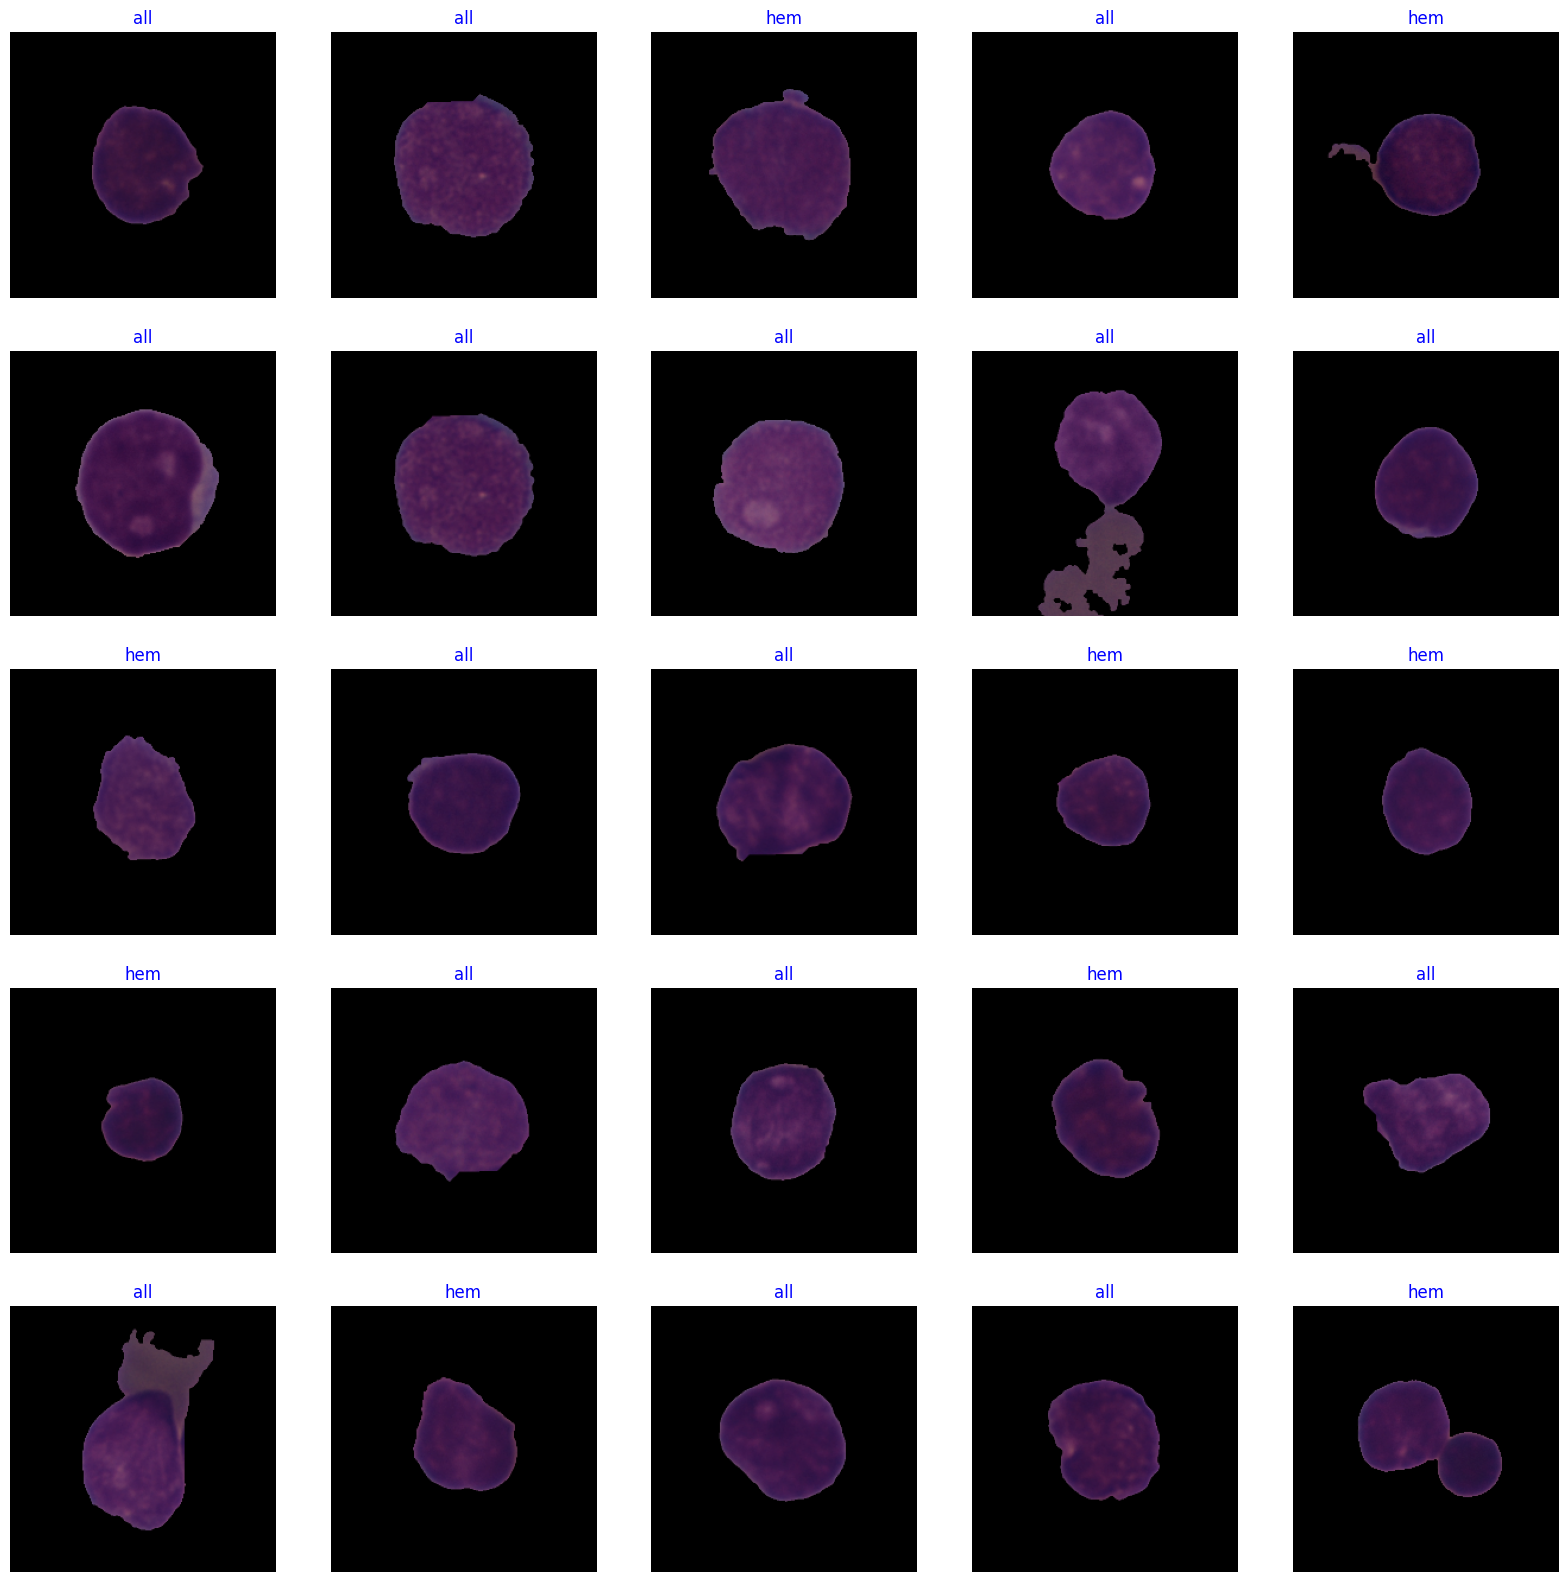

In [47]:
show_images(test_gen)

In [48]:
def plot_training(hist):
    '''
    Function ini mengambil model pelatihan dan riwayat plot akurasi dan loss dengan epoch terbaik di keduanya.
    '''

    # Define variables yang dibutuhkan
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training dan Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training dan Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


In [49]:
def plot_confusion_matrix(cm, classes, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    '''
    Function ini digunakan untuk memplot confusion matrix menggunakan sklearn package.
    '''

    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [163]:
def efficientNet_B0():
    # Create Model Structure
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)

    base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= 'imagenet', input_shape= img_shape, pooling= 'max')

    model = Sequential([
        base_model,
        BatchNormalization(),
        Dense(256, activation=relu),
        Dropout(0.2),
        Dense(2, activation='sigmoid')
    ])
    model.compile(Adamax(learning_rate= 0.0001), loss= 'binary_crossentropy', metrics= ['accuracy'])

    return model

In [164]:
history_list, model_list = [], []
train_data, val_data  = [], []
duration_list = []
kfold=5
epochs=50
fold = 1

kf = KFold(n_splits=kfold, shuffle=True, random_state=42)
fold_indices = kf.split(train_df)

for fold, (train_index, val_index) in enumerate(fold_indices):
    print(f'\nFOLD: {fold+1}')

    # Inisialisasi DataFrame baru untuk menyimpan data pelatihan dan validation
    train_subset_df = pd.DataFrame()
    valid_subset_df = pd.DataFrame()

    fold_train_df = train_df.iloc[train_index] # Bagi data menjadi set pelatihan dan validasi
    fold_valid_df = train_df.iloc[val_index]

    # Tambahkan data pelatihan dan validation pada lipatan ini ke DataFrame baru
    train_subset_df = pd.concat([train_subset_df, fold_train_df], ignore_index=True)
    valid_subset_df = pd.concat([valid_subset_df, fold_valid_df], ignore_index=True)

    train_gen = create_model_data_train(train_subset_df, batch_size) # generate data train dan valid
    valid_gen = create_model_data_valid(valid_subset_df, batch_size)

    K.clear_session()
    print('\nMODEL SUMMARY:')
    model = efficientNet_B0()
    model.summary()

    print('\nFITTING MODEL:')
    start_time = time.time() # mencatat waktu mulai
    history = model.fit(x= train_gen, epochs= epochs, verbose= 1,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)


    stop_time = time.time()
    tr_duration = stop_time - start_time
    hours = tr_duration // 3600
    minutes = (tr_duration - (hours * 3600)) // 60
    seconds = tr_duration - ((hours * 3600) + (minutes * 60))
    sum_duration = {
        'hours' : hours,
        'minutes' : minutes,
        'seconds' : seconds
    }

    duration_list.append(sum_duration)

    history_list.append(history)
    model_list.append(model)

    train_data.append(train_gen)
    val_data.append(valid_gen)


FOLD: 1
Found 5167 validated image filenames belonging to 2 classes.
Found 1292 validated image filenames belonging to 2 classes.

MODEL SUMMARY:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)   


FOLD: 1


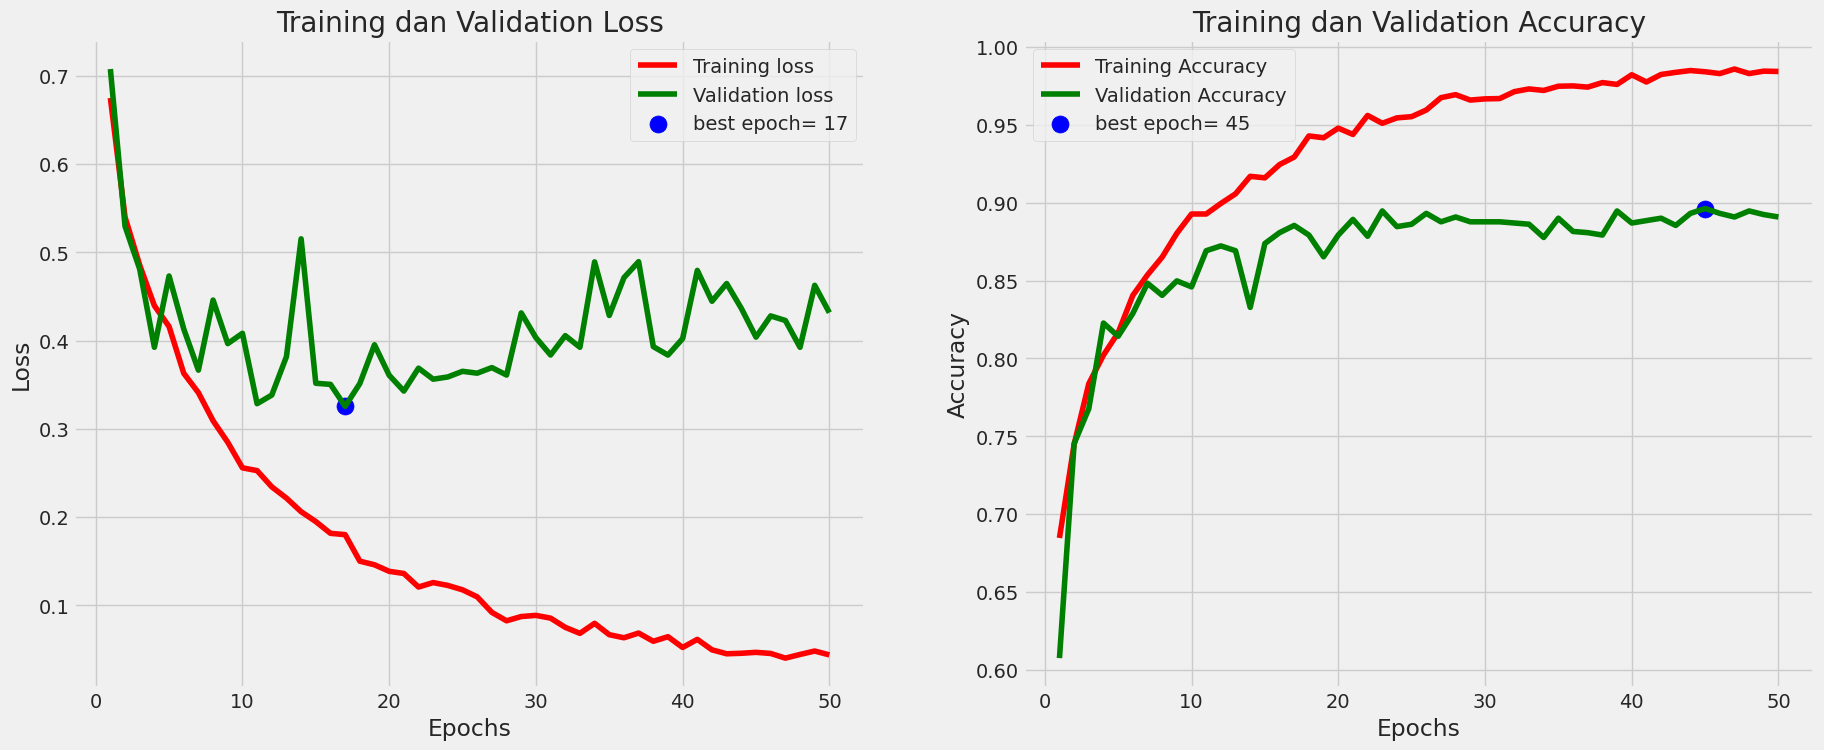


FOLD: 2


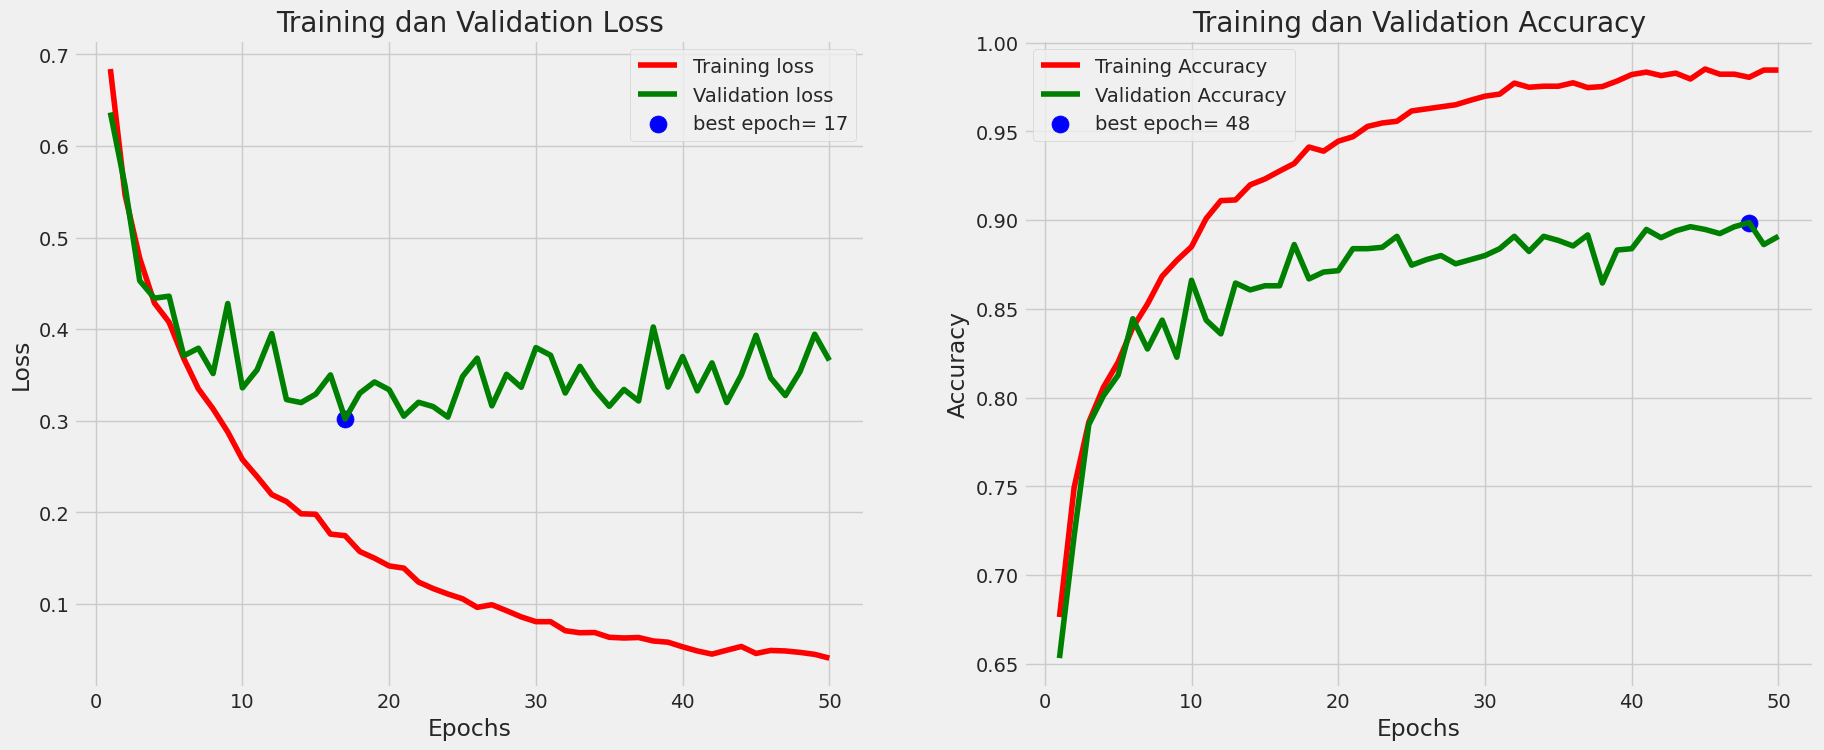


FOLD: 3


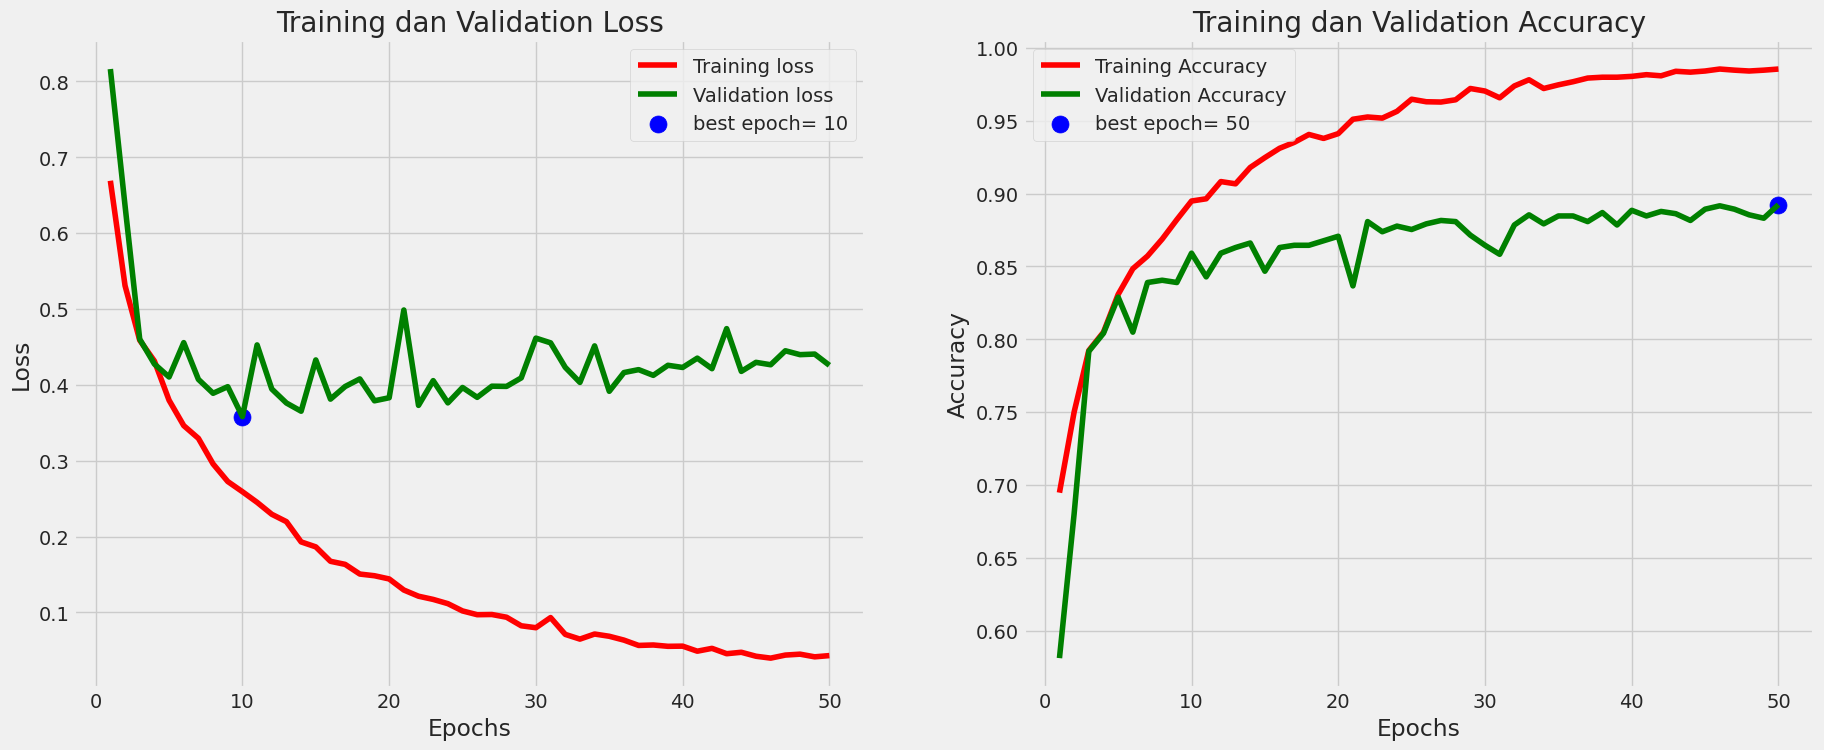


FOLD: 4


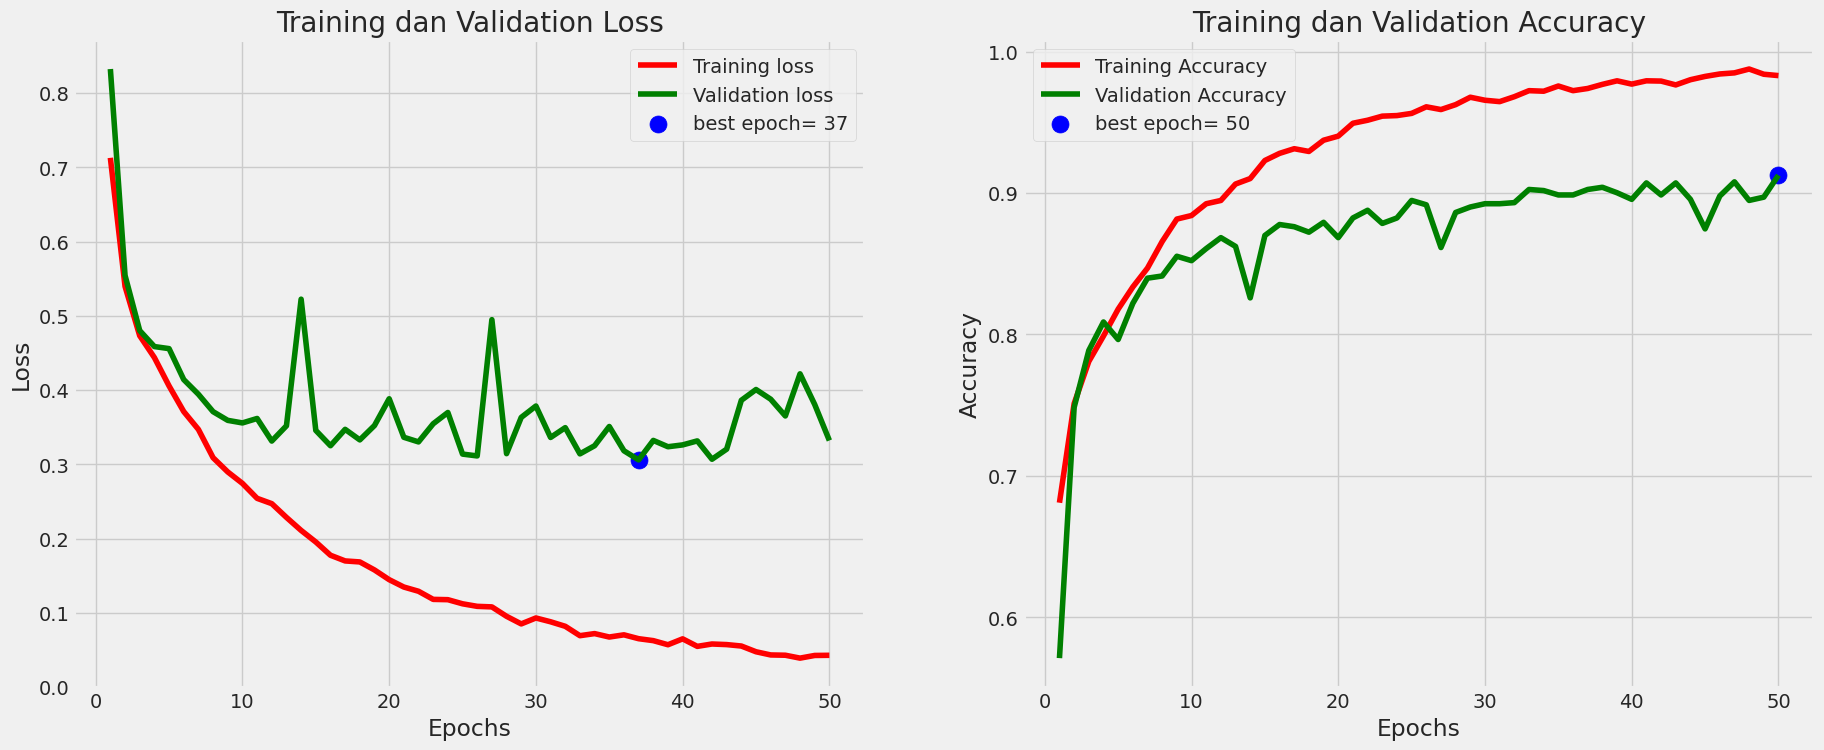


FOLD: 5


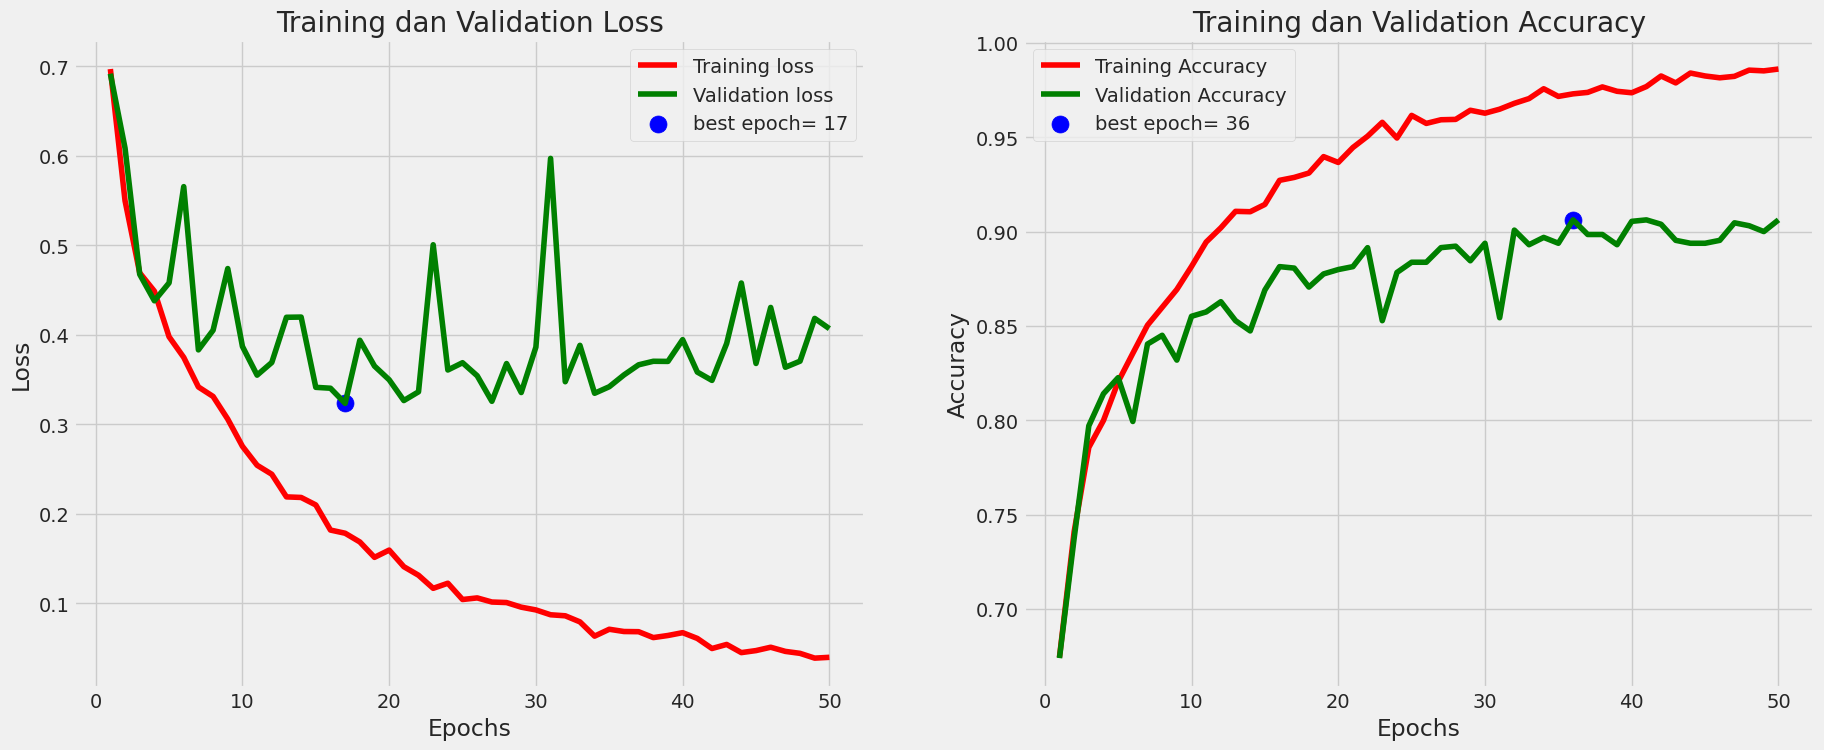

In [165]:
for fold, history in enumerate(history_list):
    print(f'\nFOLD: {fold+1}')
    plot_training(history)

In [166]:
test_batch_size = 32
validation_accuracies = []

for fold, model in enumerate(model_list):
    print(f'\nFOLD: {fold+1}')
    train_score = model.evaluate(train_data[fold], batch_size=test_batch_size, verbose= 1)
    valid_score = model.evaluate(val_data[fold], batch_size=test_batch_size, verbose= 1)

    print('-' * 20)
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Validation Loss: ", valid_score[0])
    print("Validation Accuracy: ", valid_score[1])
    print('-' * 20)

    validation_accuracies.append(valid_score[1])
    hours = duration_list[fold]['hours']
    minutes = duration_list[fold]['minutes']
    seconds = duration_list[fold]['seconds']

    msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
    print(msg)

best_fold = np.argmax(validation_accuracies)
best_model = model_list[best_fold]
print ("Best Fold berada pada : ",best_fold)
print (best_model)


FOLD: 1
41/41 [==============================] - 4s 92ms/step - loss: 0.4316 - accuracy: 0.8909
--------------------
Train Loss:  0.0023762087803333998
Train Accuracy:  0.9998064637184143
--------------------
Validation Loss:  0.4315544068813324
Validation Accuracy:  0.8908668756484985
--------------------
training elapsed time was 0.0 hours, 18.0 minutes, 0.58 seconds)

FOLD: 2
41/41 [==============================] - 4s 85ms/step - loss: 0.3658 - accuracy: 0.8909
--------------------
Train Loss:  0.002698438474908471
Train Accuracy:  0.9996129274368286
--------------------
Validation Loss:  0.36583784222602844
Validation Accuracy:  0.8908668756484985
--------------------
training elapsed time was 0.0 hours, 17.0 minutes, 57.56 seconds)

FOLD: 3
41/41 [==============================] - 4s 86ms/step - loss: 0.4258 - accuracy: 0.8924
--------------------
Train Loss:  0.0034866982605308294
Train Accuracy:  0.9998064637184143
--------------------
Validation Loss:  0.42582687735557556
Val

In [167]:
preds = best_model.predict_generator(test_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

51/51 [==============================] - 19s 162ms/step
[0 0 1 ... 1 1 1]


              precision    recall  f1-score   support

         all       0.89      0.92      0.91       808
         hem       0.92      0.89      0.90       807

    accuracy                           0.91      1615
   macro avg       0.91      0.91      0.91      1615
weighted avg       0.91      0.91      0.91      1615



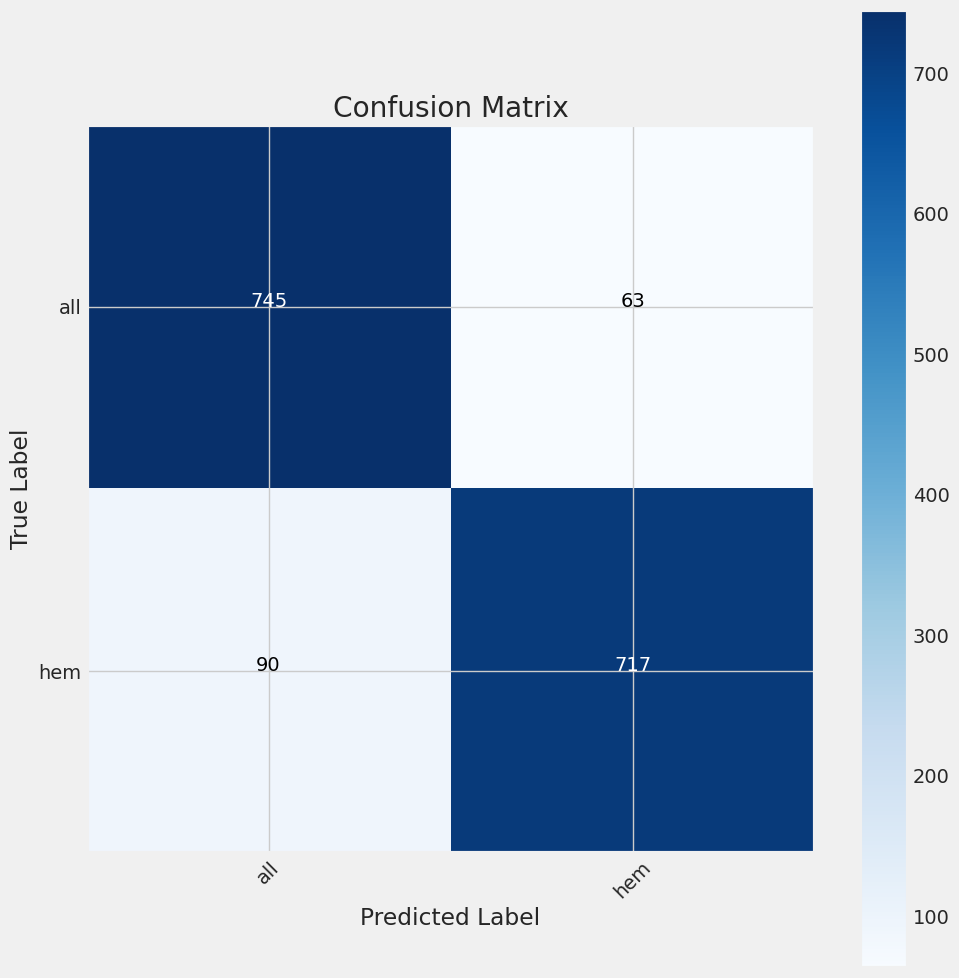

In [168]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

    # Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

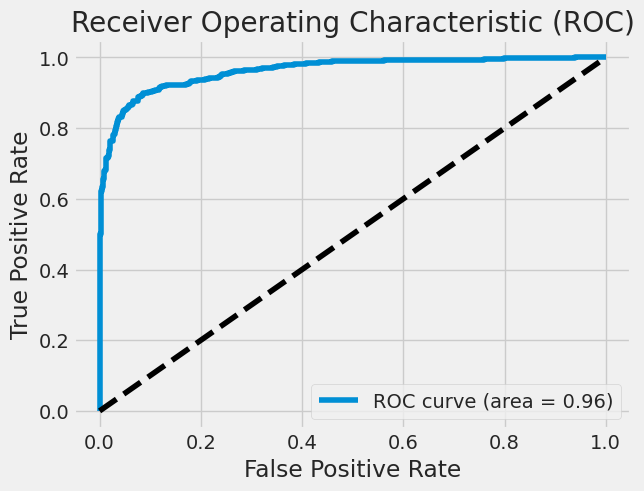

In [169]:
from sklearn import metrics


y_prob = []

for data in preds:
    y_prob.append(data[1])

fpr, tpr, thresholds = metrics.roc_curve(test_gen.classes, y_prob)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')  # Garis diagonal untuk klasifikasi acak
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()